# Exploratory Data Analysis for Exportaciones and Importaciones regarding TIE

In [135]:
import warnings
warnings.filterwarnings('ignore')

In [136]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

# Define the directory where the files are located
directory = "Data_Analysis"

# Define the directory where the files are located
exportaciones_file_path = "Data_Analysis/Exportaciones_kWh.xlsx"
importaciones_file_path = "Data_Analysis/Importaciones_kWh.xlsx"

# Read the data from the Excel files
exportaciones_df = pd.read_excel(exportaciones_file_path, parse_dates=['Fecha'])
importaciones_df = pd.read_excel(importaciones_file_path, parse_dates=['Fecha'])

# Ensure dates are correctly parsed and filtered
exportaciones_df['Fecha'] = pd.to_datetime(exportaciones_df['Fecha'], format='%Y-%m-%d', errors='coerce')
importaciones_df['Fecha'] = pd.to_datetime(importaciones_df['Fecha'], format='%Y-%m-%d', errors='coerce')

# Convert kWh to MWh for all hourly columns and sum across all hours
exportaciones_df['Total_MWh'] = exportaciones_df.iloc[:, 2:26].sum(axis=1) / 1000
importaciones_df['Total_MWh'] = importaciones_df.iloc[:, 2:26].sum(axis=1) / 1000

# Convert kWh to GWh for all hourly columns and sum across all hours
exportaciones_df['Total_GWh'] = exportaciones_df.iloc[:, 2:26].sum(axis=1) / 1e6
importaciones_df['Total_GWh'] = importaciones_df.iloc[:, 2:26].sum(axis=1) / 1e6

# Define a custom color palette
custom_palette_quantities = {
    "Exportaciones": "tab:green",
    "Importaciones": "tab:orange"
}

# Define a custom color palette
custom_palette_enlace = {
    "Ecuador 138 kV": "tab:brown",
    "Ecuador 230 kV": "tab:blue"
}

# Capacity in MW
capacity = {
    "Ecuador 138 kV": 35,
    "Ecuador 230 kV": 500
}

## Intercambio de Energía Eléctrica entre Colombia y Ecuador

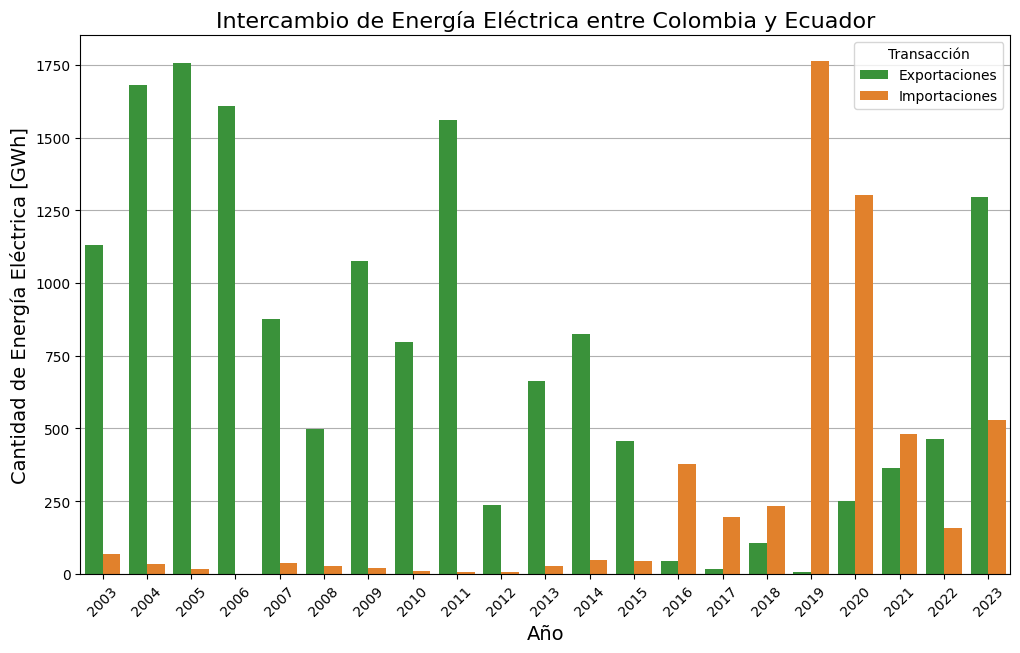

Year  Exportaciones  Importaciones
0   2003    1129.263480      67.202726
1   2004    1681.088143      34.974273
2   2005    1757.881370      16.028709
3   2006    1608.628889       1.070411
4   2007     876.602276      38.392579
5   2008     497.433130      25.821846
6   2009    1076.725567      20.764088
7   2010     797.689992       9.744971
8   2011    1561.701614       8.218484
9   2012     236.034522       6.510217
10  2013     662.343692      28.502361
11  2014     824.020394      46.858536
12  2015     457.245162      45.193041
13  2016      43.915631     378.267154
14  2017      18.517948     194.230942
15  2018     106.071596     233.156155
16  2019       5.829220    1764.821148
17  2020     250.795342    1301.589395
18  2021     363.803488     479.421003
19  2022     465.299154     159.151230
20  2023    1296.576463     530.088760

In [137]:
# Group the data by year and sum to get annual values
exportaciones_df['Year'] = exportaciones_df['Fecha'].dt.year
importaciones_df['Year'] = importaciones_df['Fecha'].dt.year

# Create a new DataFrame for seaborn
energy_df = pd.DataFrame({
    'Year': pd.concat([exportaciones_df['Year'], importaciones_df['Year']]).unique()
}).sort_values('Year', ascending=True)

energy_df['Exportaciones'] = energy_df['Year'].map(exportaciones_df.groupby('Year')['Total_GWh'].sum())
energy_df['Importaciones'] = energy_df['Year'].map(importaciones_df.groupby('Year')['Total_GWh'].sum())

# Melt the DataFrame to long-form for seaborn
energy_long_df = pd.melt(energy_df, id_vars='Year', var_name='Transaction', value_name='GWh')

# Plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=energy_long_df, x='Year', y='GWh', hue='Transaction', palette=custom_palette_quantities, hue_order=["Exportaciones", "Importaciones"])

plt.title('Intercambio de Energía Eléctrica entre Colombia y Ecuador', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad de Energía Eléctrica [GWh]', fontsize=14)
plt.legend(title='Transacción')
plt.xticks(rotation=45)

# Add grid only on the y-axis
ax.yaxis.grid(True)  # Enable the grid on the y-axis
ax.set_axisbelow(True)  # Ensure the grid is behind the plot

plt.show()

energy_df

## Capacidad de Exportación e Importación después de las Restricciones

### Capacidad Mensual

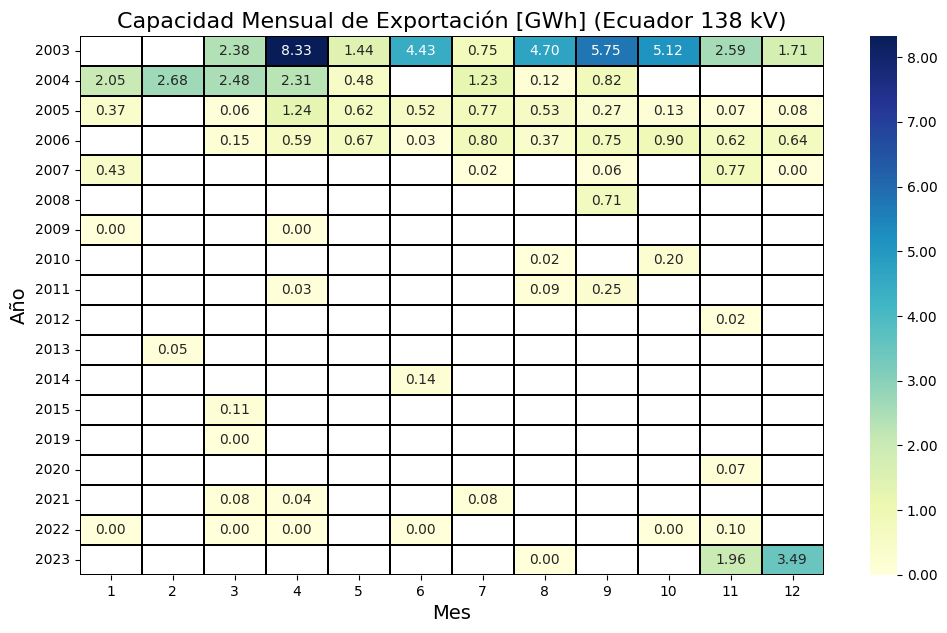

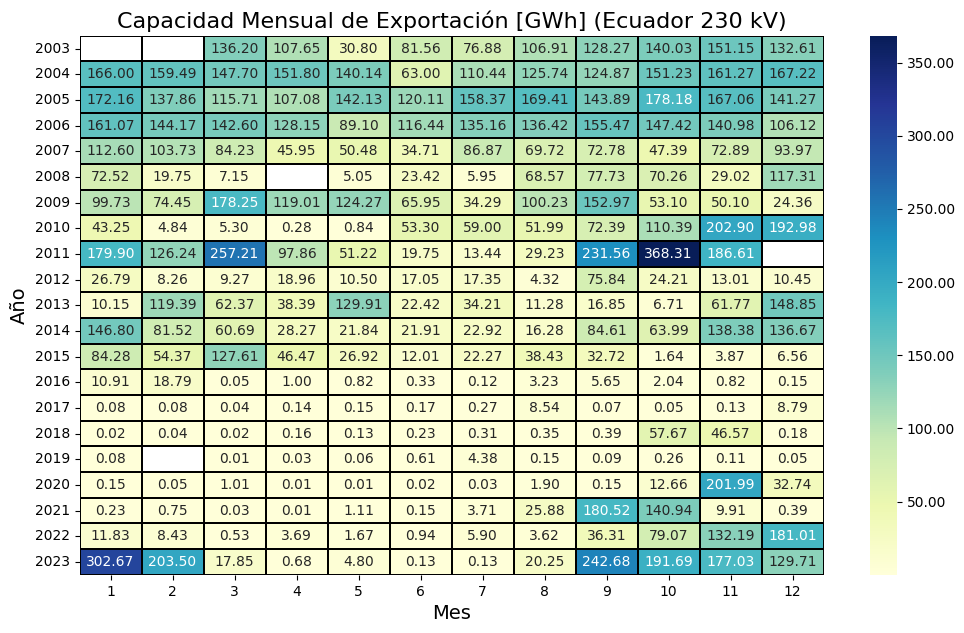

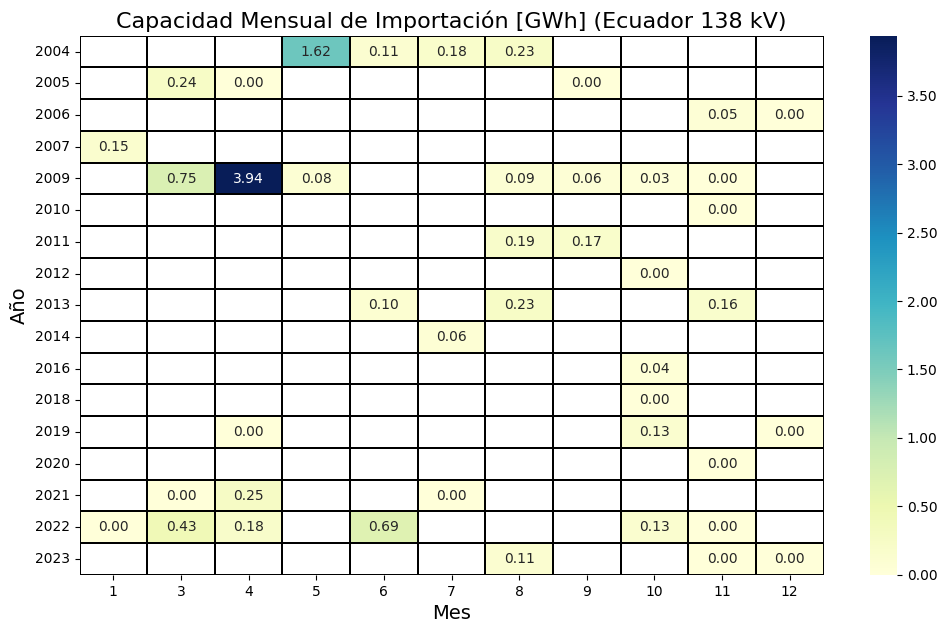

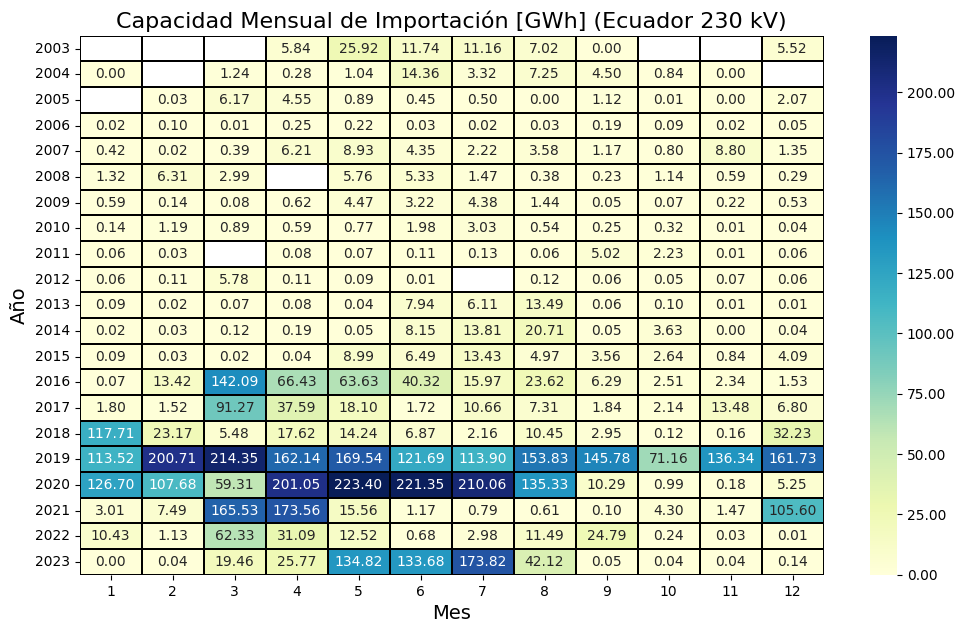

In [138]:
# Aggregate to monthly data
exportaciones_heatmap_df = exportaciones_df.copy()
importaciones_heatmap_df = importaciones_df.copy()

# Aggregate to monthly data
exportaciones_heatmap_df['Year'] = exportaciones_heatmap_df['Fecha'].dt.year
exportaciones_heatmap_df['Month'] = exportaciones_heatmap_df['Fecha'].dt.month
importaciones_heatmap_df['Year'] = importaciones_heatmap_df['Fecha'].dt.year
importaciones_heatmap_df['Month'] = importaciones_heatmap_df['Fecha'].dt.month

exportaciones_heatmap_monthly = exportaciones_heatmap_df.groupby(['Year', 'Month', 'Enlace'])['Total_GWh'].sum().reset_index()
importaciones_heatmap_monthly = importaciones_heatmap_df.groupby(['Year', 'Month', 'Enlace'])['Total_GWh'].sum().reset_index()

# Define a function to format the annotations
def annot_format(val):
    return f"{val:,.2f}"

# Define a function to plot heatmaps
def plot_heatmap(df, enlace, title):
    df_filtered = df[df['Enlace'] == enlace]
    df_pivot = df_filtered.pivot_table(index='Year', columns='Month', values='Total_GWh', aggfunc='sum')
    plt.figure(figsize=(12, 7))
    ax = sns.heatmap(df_pivot, cmap="YlGnBu", linewidths=0.1, linecolor="black", annot=True, fmt="", cbar_kws={'format': '%.2f'})
    
    # Format the annotations
    for text in ax.texts:
        text.set_text(f'{float(text.get_text()):,.2f}')

    plt.title(title, fontsize=16)
    plt.xlabel('Mes', fontsize=14)
    plt.ylabel('Año', fontsize=14)
    plt.show()

# Plot heatmaps for each case
plot_heatmap(exportaciones_heatmap_monthly, 'Ecuador 138 kV', 'Capacidad Mensual de Exportación [GWh] (Ecuador 138 kV)')
plot_heatmap(exportaciones_heatmap_monthly, 'Ecuador 230 kV', 'Capacidad Mensual de Exportación [GWh] (Ecuador 230 kV)')
plot_heatmap(importaciones_heatmap_monthly, 'Ecuador 138 kV', 'Capacidad Mensual de Importación [GWh] (Ecuador 138 kV)')
plot_heatmap(importaciones_heatmap_monthly, 'Ecuador 230 kV', 'Capacidad Mensual de Importación [GWh] (Ecuador 230 kV)')

### Capacidad Diaria

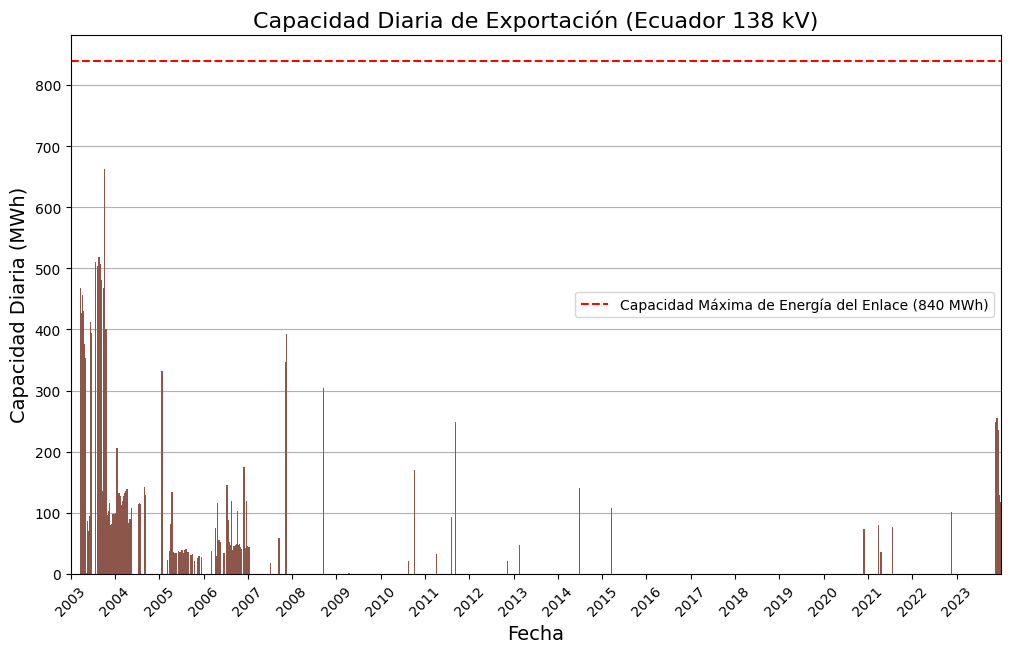

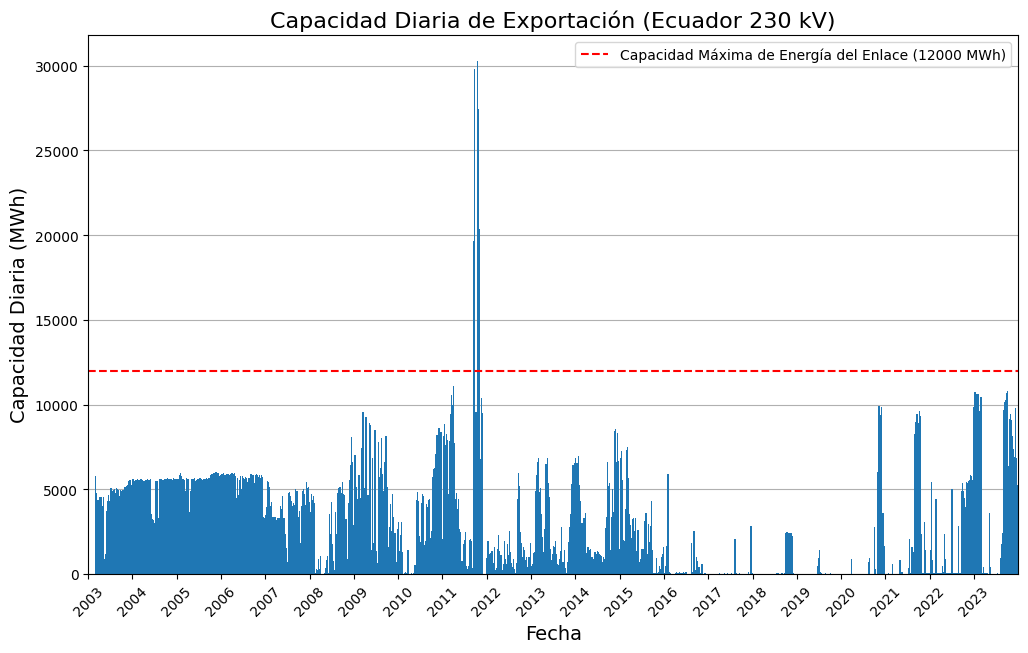

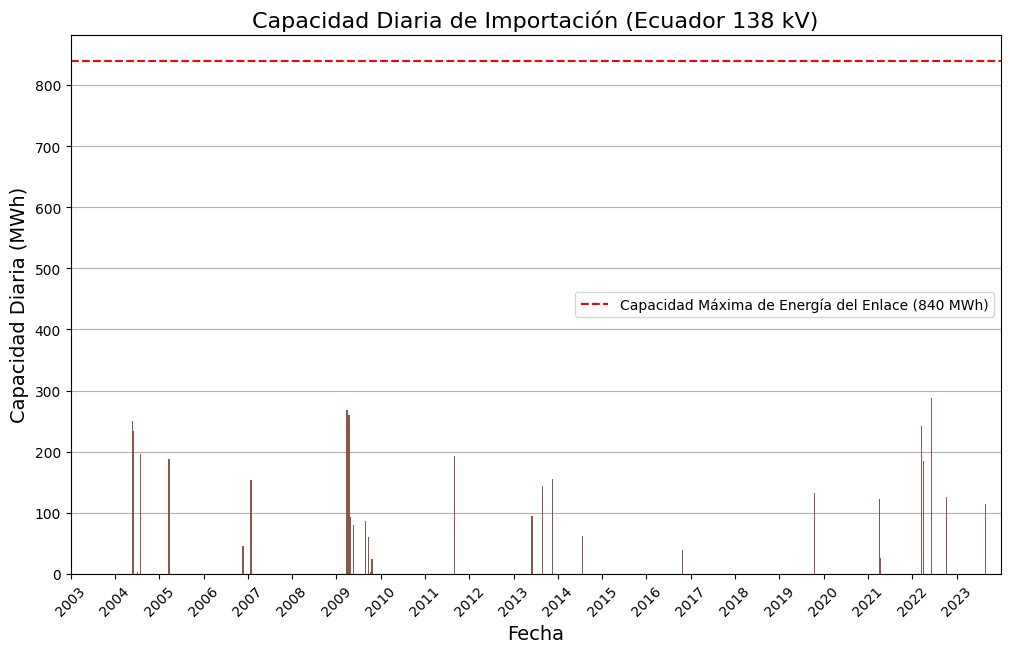

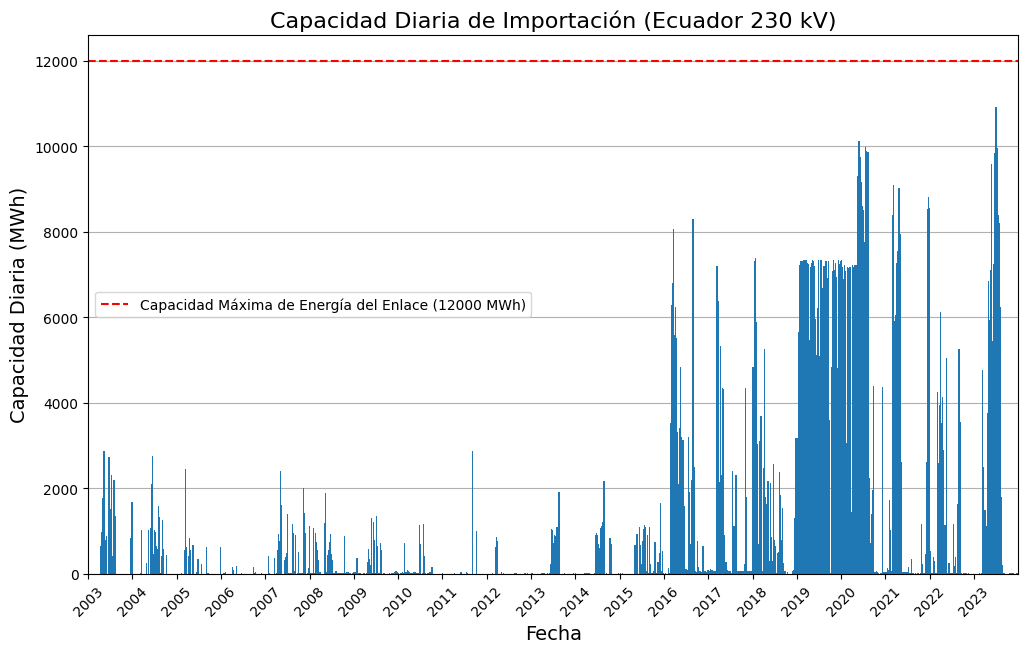

In [139]:
# Group by 'Fecha' and 'Enlace' and sum the 'Total_MWh'
exportaciones_daily = exportaciones_df.groupby(['Fecha', 'Enlace'])['Total_MWh'].sum().reset_index()
importaciones_daily = importaciones_df.groupby(['Fecha', 'Enlace'])['Total_MWh'].sum().reset_index()

# Plotting function
def plot_barplot_daily_energy_capacity_per_enlace(df, enlace, title):
    plt.figure(figsize=(12, 7))
    df_filtered = df[df['Enlace'] == enlace]
    df_filtered = df_filtered.sort_values('Fecha', ascending=True)
    bar_width = 10  # width of the bars
    plt.bar(df_filtered['Fecha'], df_filtered['Total_MWh'], width=bar_width, color=custom_palette_enlace[enlace])
    plt.title(title, fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Capacidad Diaria (MWh)', fontsize=14)
    max_capacity_mwh = capacity[enlace] * 24 # Daily Maximum Capacity
    plt.axhline(y=max_capacity_mwh, color='red', linestyle='--', label=f'Capacidad Máxima de Energía del Enlace ({max_capacity_mwh} MWh)')
    plt.legend()

    ax = plt.gca()
    #ax.set_xticks(pd.date_range(start='2003-01-01', end='2023-12-31', freq='YS'))
    #ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')
    #ax.set_xticklabels([pd.to_datetime(tick).year for tick in ax.get_xticks()])

    # Set the axis limits
    ax.set_xlim(pd.to_datetime('2003-01-01'), pd.to_datetime('2023-12-31'))

    # Set major ticks format to show the first day of each year as the year
    plt.gca().xaxis.set_major_locator(md.YearLocator())
    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.gca().yaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.show()

# Plot for each Enlace
plot_barplot_daily_energy_capacity_per_enlace(exportaciones_daily, 'Ecuador 138 kV', 'Capacidad Diaria de Exportación (Ecuador 138 kV)')
plot_barplot_daily_energy_capacity_per_enlace(exportaciones_daily, 'Ecuador 230 kV', 'Capacidad Diaria de Exportación (Ecuador 230 kV)')
plot_barplot_daily_energy_capacity_per_enlace(importaciones_daily, 'Ecuador 138 kV', 'Capacidad Diaria de Importación (Ecuador 138 kV)')
plot_barplot_daily_energy_capacity_per_enlace(importaciones_daily, 'Ecuador 230 kV', 'Capacidad Diaria de Importación (Ecuador 230 kV)')

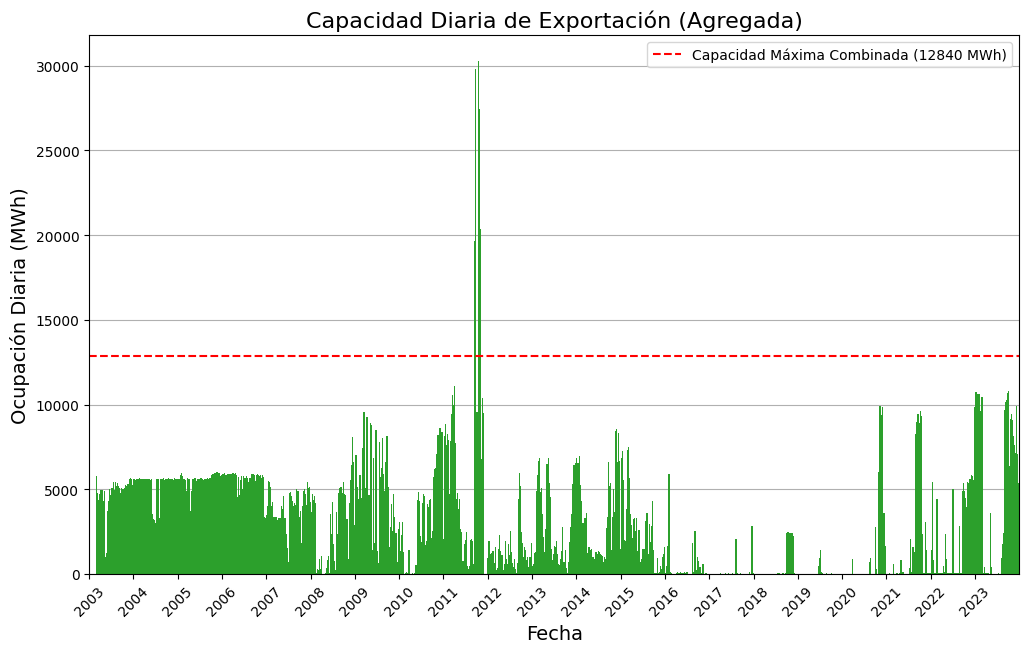

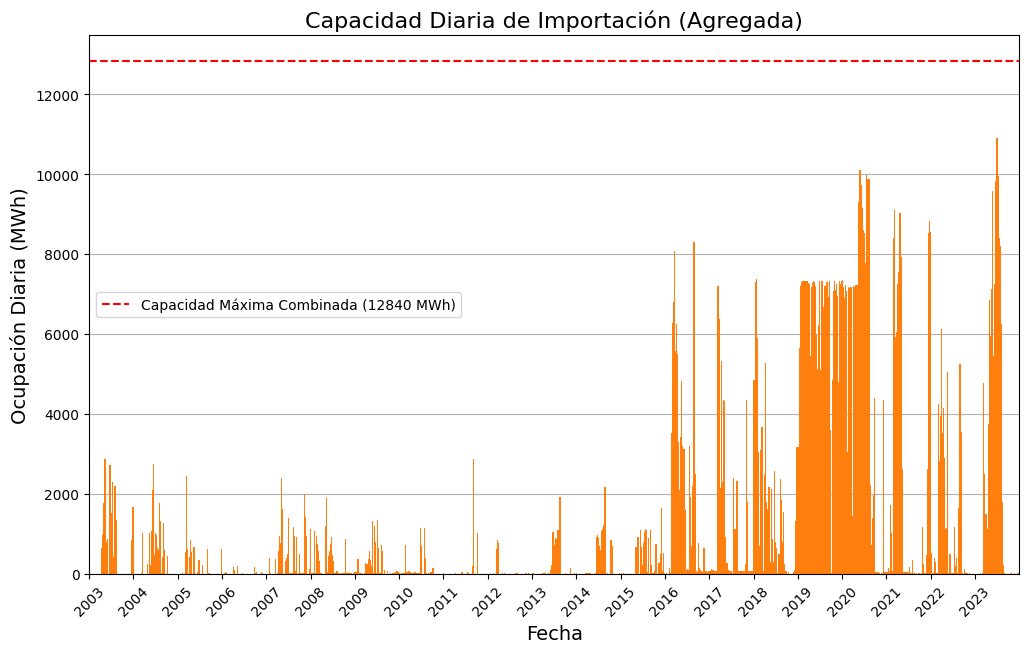

In [140]:
# Aggregate the data across all Enlaces
exportaciones_aggregated = exportaciones_df.groupby(['Fecha'])['Total_MWh'].sum().reset_index()
importaciones_aggregated = importaciones_df.groupby(['Fecha'])['Total_MWh'].sum().reset_index()

# Plotting function for aggregated data
def plot_daily_energy_capacity_aggregated(df, title, max_capacity, color):
    plt.figure(figsize=(12, 7))
    bar_width = 10  # width of the bars
    plt.bar(df['Fecha'], df['Total_MWh'], width=bar_width, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Ocupación Diaria (MWh)', fontsize=14)
    plt.axhline(y=max_capacity * 24, color='red', linestyle='--', label=f'Capacidad Máxima Combinada ({max_capacity * 24} MWh)')
    plt.legend()

    ax = plt.gca()
    #ax.set_xticks(pd.date_range(start='2003-01-01', end='2023-12-31', freq='YS'))
    #ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')
    #ax.set_xticklabels([pd.to_datetime(tick).year for tick in ax.get_xticks()])

    # Set the axis limits
    ax.set_xlim(pd.to_datetime('2003-01-01'), pd.to_datetime('2023-12-31'))

    # Set major ticks format to show the first day of each year as the year
    plt.gca().xaxis.set_major_locator(md.YearLocator())
    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.gca().yaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.show()

# Combined maximum capacity in MW
combined_max_capacity = capacity["Ecuador 138 kV"] + capacity["Ecuador 230 kV"]

# Plot aggregated data
plot_daily_energy_capacity_aggregated(exportaciones_aggregated, 'Capacidad Diaria de Exportación (Agregada)', combined_max_capacity, custom_palette_quantities['Exportaciones'])
plot_daily_energy_capacity_aggregated(importaciones_aggregated, 'Capacidad Diaria de Importación (Agregada)', combined_max_capacity, custom_palette_quantities['Importaciones'])

### Capacidad Horaria

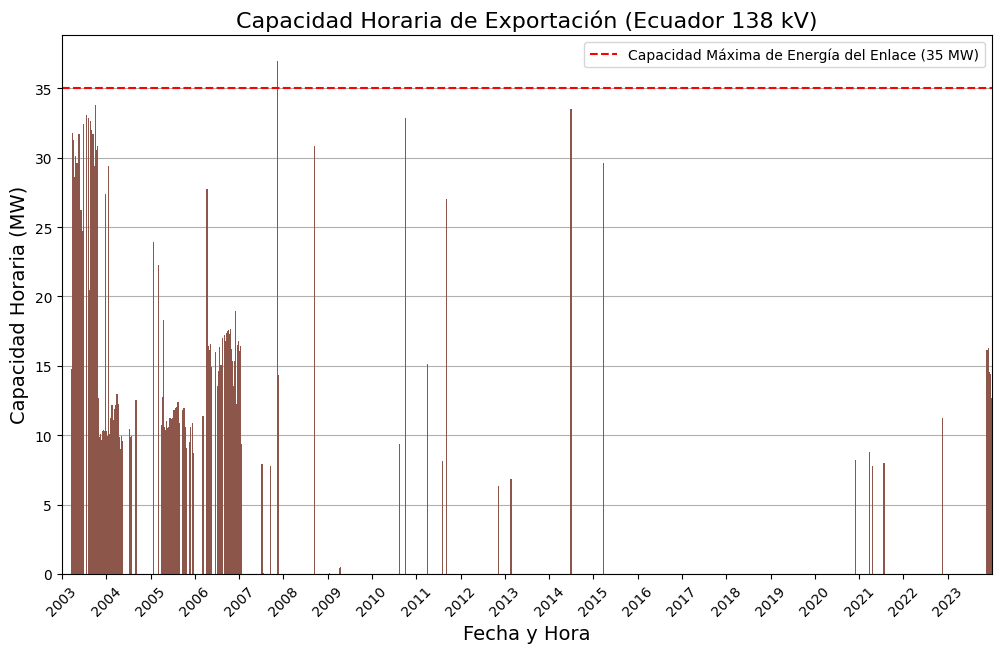

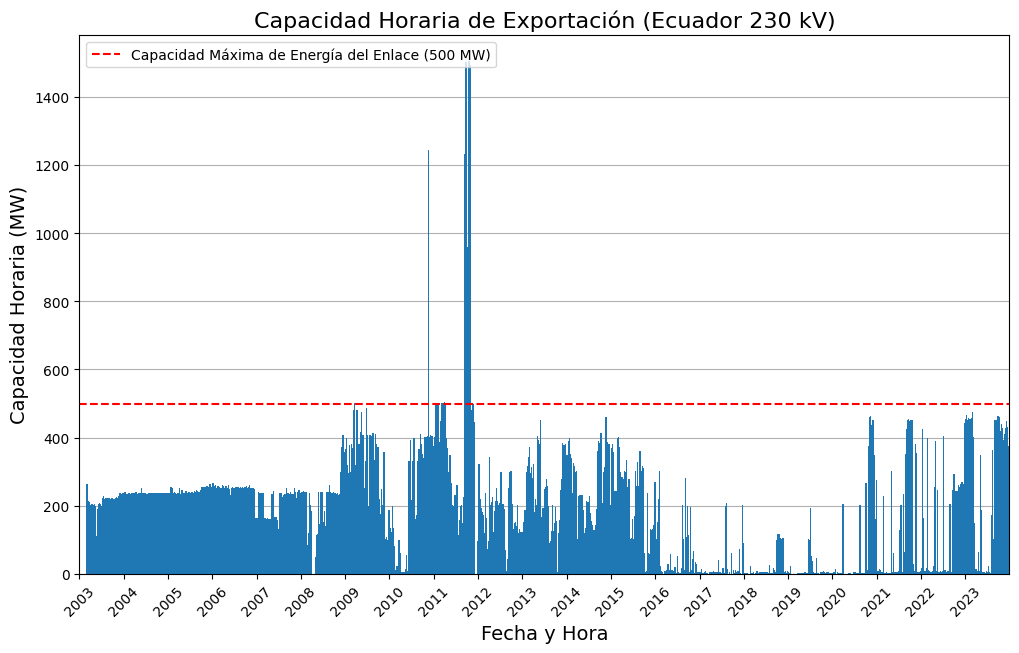

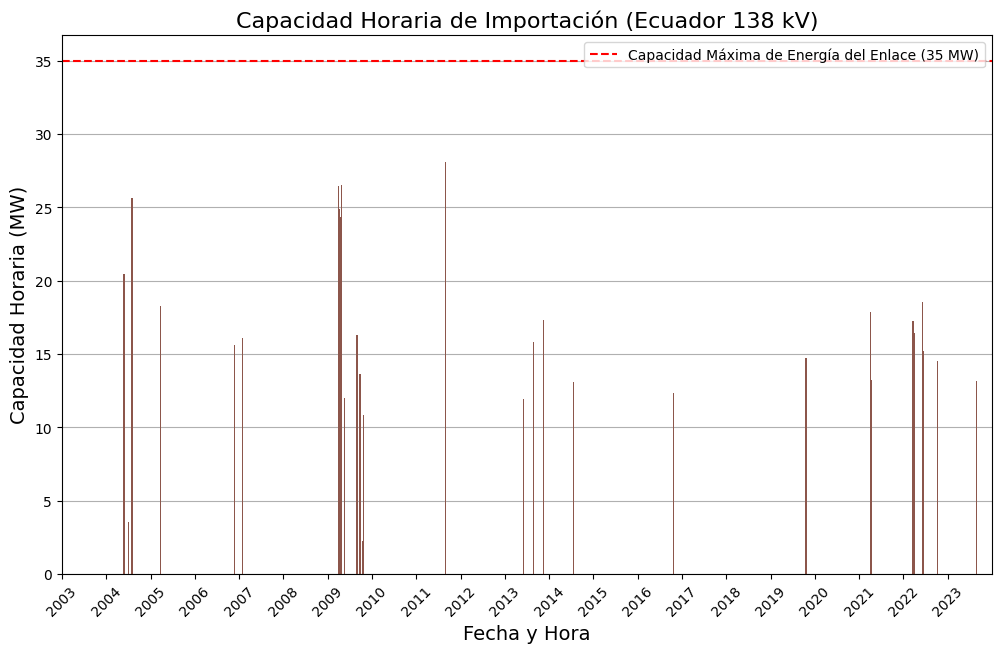

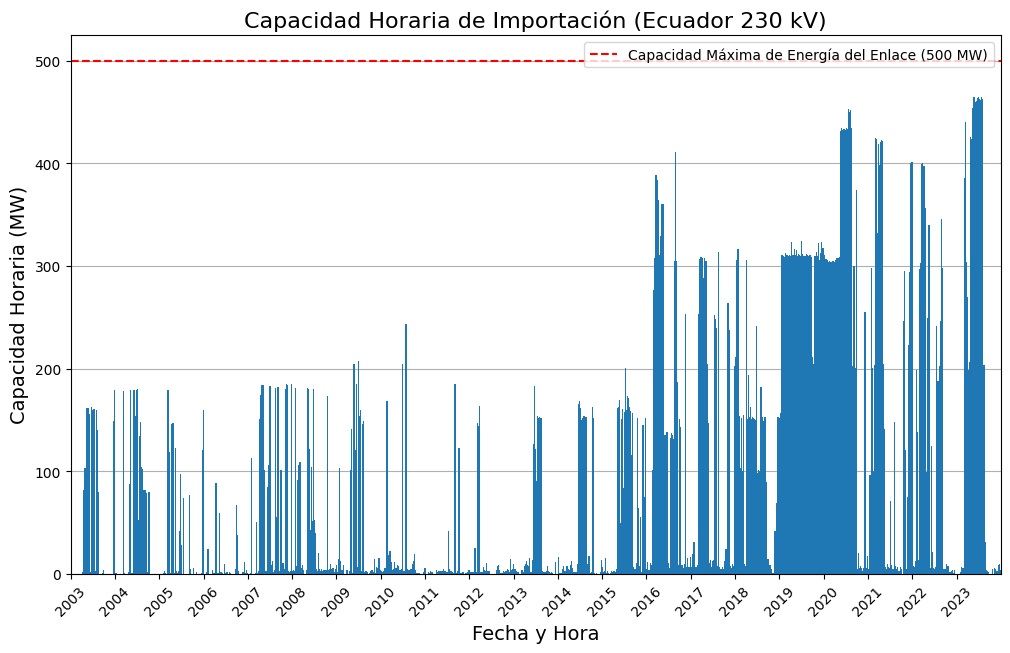

In [141]:
# Create copies of the dataframes for melting
exportaciones_mw_per_hour_df = exportaciones_df.copy()
importaciones_mw_per_hour_df = importaciones_df.copy()

# Convert kWh to MWh for all hourly columns
exportaciones_mw_per_hour_df.iloc[:, 2:26] = exportaciones_mw_per_hour_df.iloc[:, 2:26] / 1e3
importaciones_mw_per_hour_df.iloc[:, 2:26] = importaciones_mw_per_hour_df.iloc[:, 2:26] / 1e3

# print("Exportaciones columns from 2 to 26 (names):")
# print(exportaciones_mw_per_hour_df.columns[2:26])

# print("Importaciones columns from 2 to 26 (names):")
# print(importaciones_mw_per_hour_df.columns[2:26])

# Melt the dataframes to long format to include hourly data
exportaciones_long = pd.melt(exportaciones_mw_per_hour_df.drop(columns=['Total_MWh', 'Total_GWh', 'Year']), id_vars=['Fecha', 'Enlace'], var_name='Hour', value_name='Hourly_MW')
importaciones_long = pd.melt(importaciones_mw_per_hour_df.drop(columns=['Total_MWh', 'Total_GWh', 'Year']), id_vars=['Fecha', 'Enlace'], var_name='Hour', value_name='Hourly_MW')

# Combine date and hour into a single datetime column
exportaciones_long['Hour'] = exportaciones_long['Hour'].fillna(0).astype(int)
importaciones_long['Hour'] = importaciones_long['Hour'].fillna(0).astype(int)

exportaciones_long['Datetime'] = exportaciones_long['Fecha'] + pd.to_timedelta(exportaciones_long['Hour'], unit='h')
importaciones_long['Datetime'] = importaciones_long['Fecha'] + pd.to_timedelta(importaciones_long['Hour'], unit='h')

exportaciones_long = exportaciones_long.sort_values('Datetime', ascending=True)
importaciones_long = importaciones_long.sort_values('Datetime', ascending=True)

# Plotting function
def plot_barplot_hourly_energy_capacity_per_enlace(df, enlace, title):
    plt.figure(figsize=(12, 7))
    df_filtered = df[df['Enlace'] == enlace]
    df_filtered = df_filtered.sort_values('Fecha', ascending=True)
    bar_width = 10  # width of the bars
    plt.bar(df_filtered['Datetime'], df_filtered['Hourly_MW'], width=bar_width, color=custom_palette_enlace[enlace])
    plt.title(title, fontsize=16)
    plt.xlabel('Fecha y Hora', fontsize=14)
    plt.ylabel('Capacidad Horaria (MW)', fontsize=14)
    max_capacity_mwh = capacity[enlace]  # Hourly Maximum Capacity
    plt.axhline(y=max_capacity_mwh, color='red', linestyle='--', label=f'Capacidad Máxima de Energía del Enlace ({max_capacity_mwh} MW)')
    plt.legend()

    ax = plt.gca()
    #ax.set_xticks(pd.date_range(start='2003-01-01', end='2023-12-31', freq='YS'))
    #ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')
    #ax.set_xticklabels([pd.to_datetime(tick).year for tick in ax.get_xticks()])

    # Set the axis limits
    ax.set_xlim(pd.to_datetime('2003-01-01'), pd.to_datetime('2023-12-31'))

    # Set major ticks format to show the first day of each year as the year
    plt.gca().xaxis.set_major_locator(md.YearLocator())
    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.gca().yaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.show()

# Plot for each Enlace
plot_barplot_hourly_energy_capacity_per_enlace(exportaciones_long, 'Ecuador 138 kV', 'Capacidad Horaria de Exportación (Ecuador 138 kV)')
plot_barplot_hourly_energy_capacity_per_enlace(exportaciones_long, 'Ecuador 230 kV', 'Capacidad Horaria de Exportación (Ecuador 230 kV)')
plot_barplot_hourly_energy_capacity_per_enlace(importaciones_long, 'Ecuador 138 kV', 'Capacidad Horaria de Importación (Ecuador 138 kV)')
plot_barplot_hourly_energy_capacity_per_enlace(importaciones_long, 'Ecuador 230 kV', 'Capacidad Horaria de Importación (Ecuador 230 kV)')

## Ocupación de Exportación e Importación después de las Restricciones

### Ocupación Anual

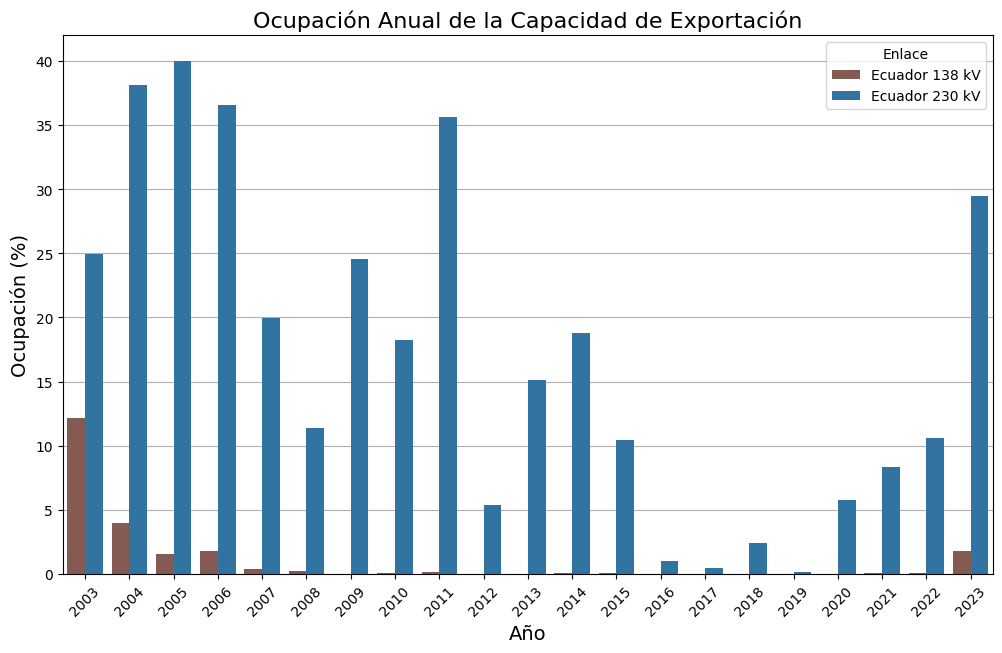

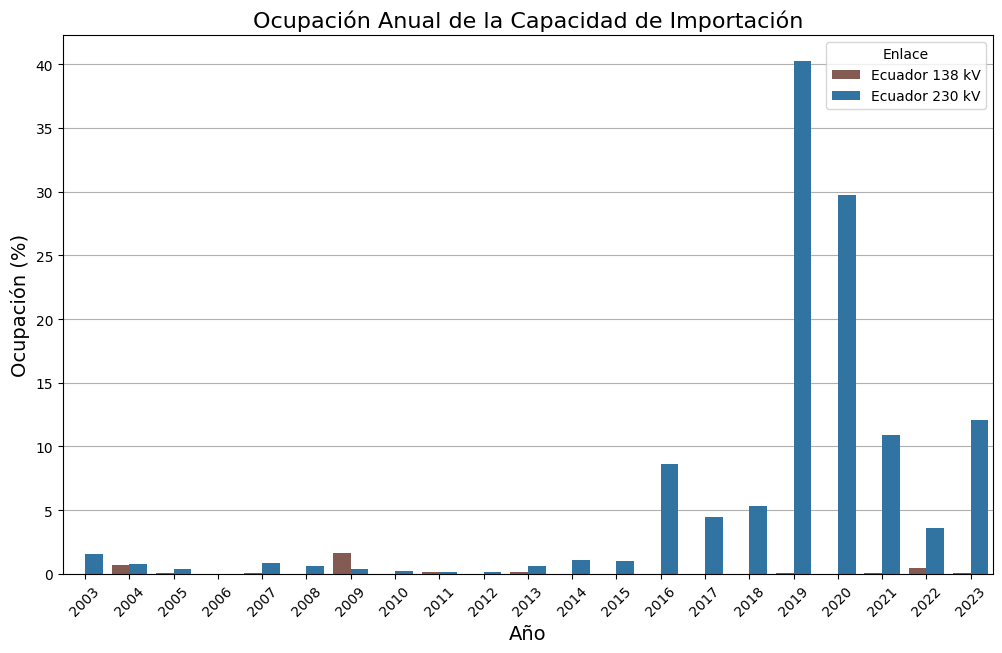

In [142]:
exportaciones_annual = exportaciones_df.groupby(['Year', 'Enlace'])['Total_MWh'].sum().reset_index()
importaciones_annual = importaciones_df.groupby(['Year', 'Enlace'])['Total_MWh'].sum().reset_index()

# Calculate occupation percentage
def calculate_anual_occupation(df, capacity):
    df['Occupation'] = df.apply(lambda row: ((row['Total_MWh']) / (capacity[row['Enlace']] * 8760)) * 100, axis=1) # Annual Maximum Capacity
    return df

exportaciones_annual = calculate_anual_occupation(exportaciones_annual, capacity)
importaciones_annual = calculate_anual_occupation(importaciones_annual, capacity)

# Plotting
def plot_barplot_annual_percentage_occupation(df, title):
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df, x='Year', y='Occupation', hue='Enlace', hue_order=["Ecuador 138 kV", "Ecuador 230 kV"], palette=custom_palette_enlace)
    plt.title(title, fontsize=16)
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Ocupación (%)', fontsize=14)
    plt.legend(title='Enlace')
    plt.xticks(rotation=45)
    ax.yaxis.grid(True)
    ax.set_axisbelow(True)
    plt.show()

plot_barplot_annual_percentage_occupation(exportaciones_annual, 'Ocupación Anual de la Capacidad de Exportación')
plot_barplot_annual_percentage_occupation(importaciones_annual, 'Ocupación Anual de la Capacidad de Importación')

### Ocupación Diaria

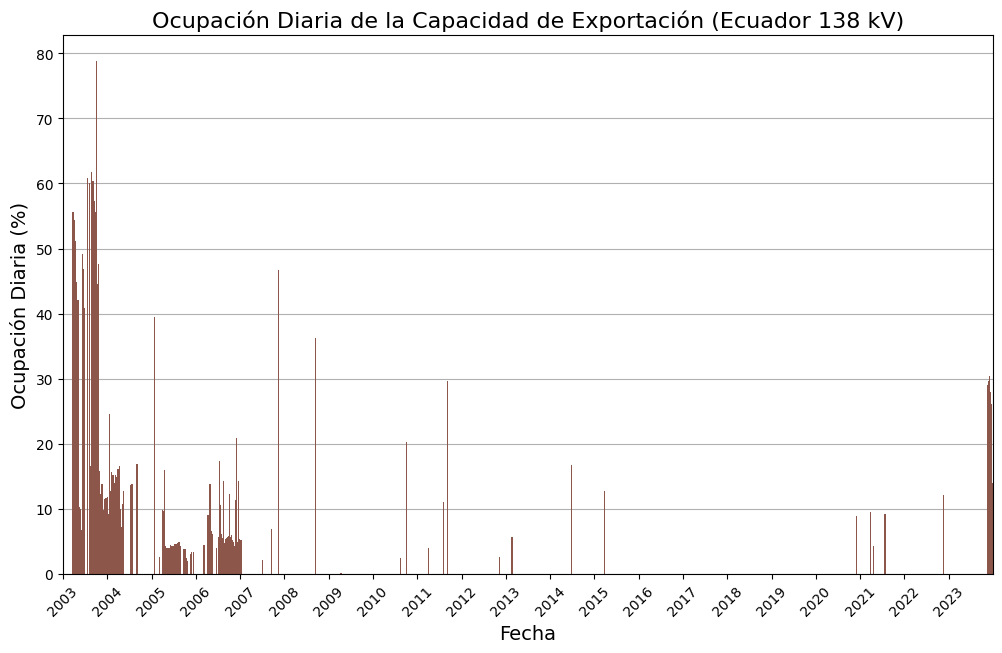

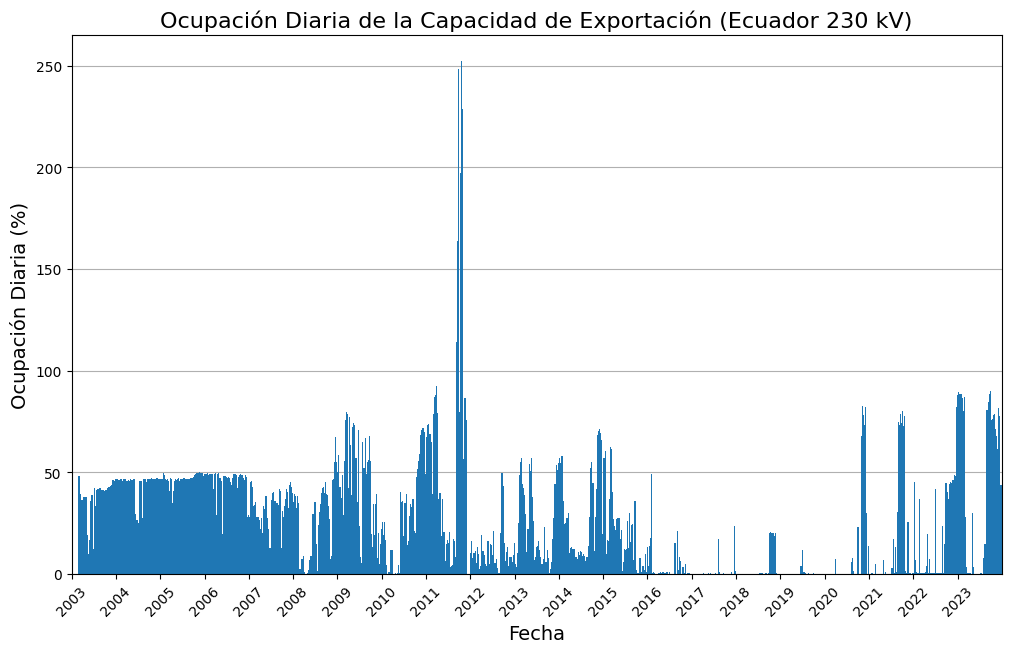

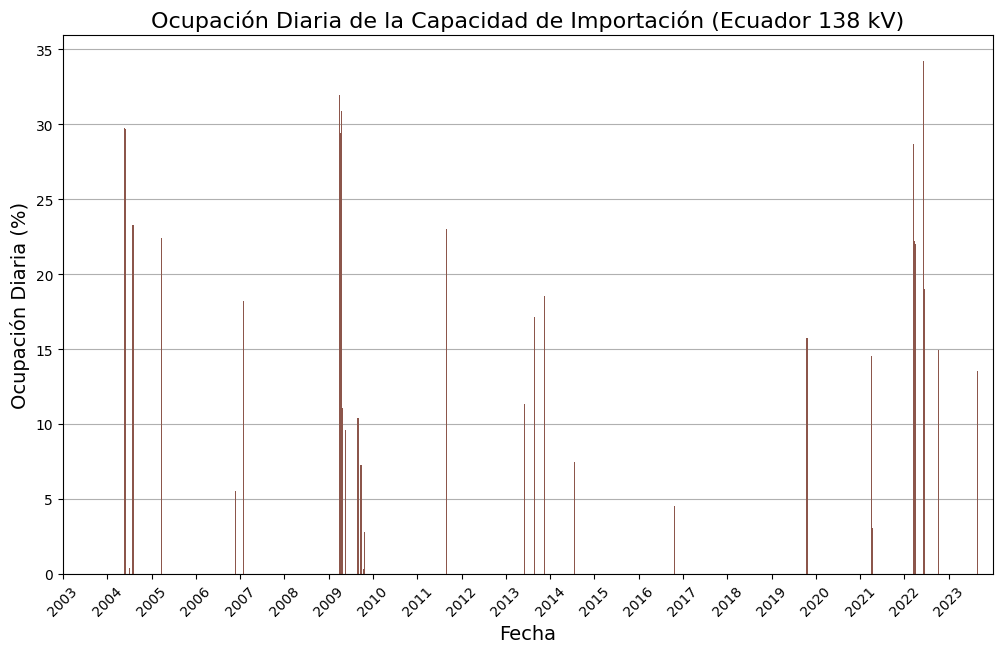

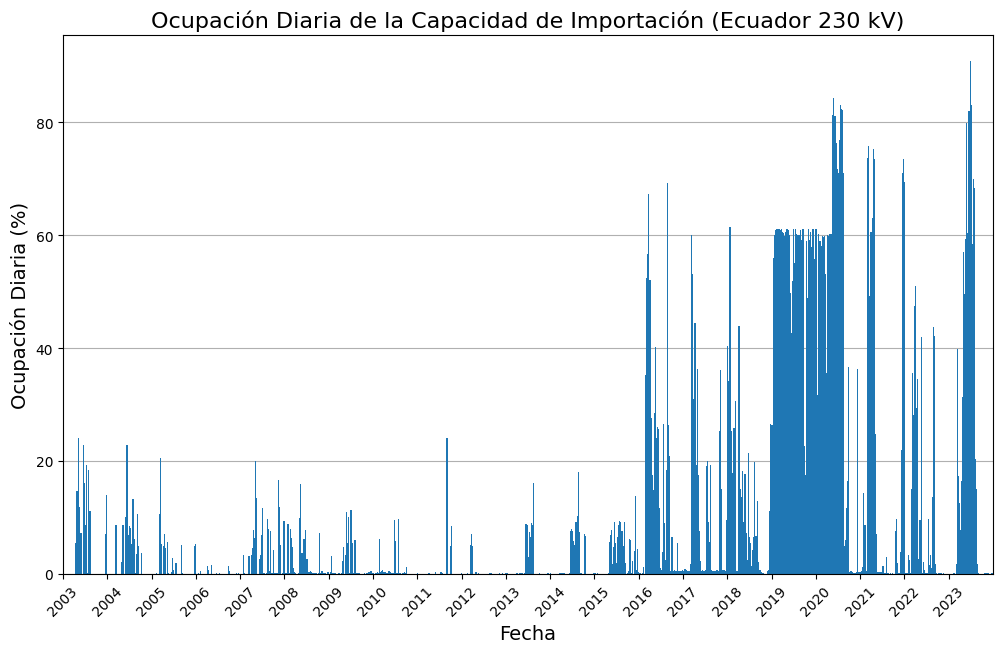

In [143]:
exportaciones_daily = exportaciones_df.groupby(['Fecha', 'Enlace'])['Total_MWh'].sum().reset_index()
importaciones_daily = importaciones_df.groupby(['Fecha', 'Enlace'])['Total_MWh'].sum().reset_index()

# Calculate occupation percentage
def calculate_daily_occupation(df, capacity):
    df['Occupation'] = df.apply(lambda row: (row['Total_MWh']) / (capacity[row['Enlace']] * 24) * 100, axis=1) # Daily Maximum Capacity
    return df

exportaciones_daily = calculate_daily_occupation(exportaciones_daily, capacity)
importaciones_daily = calculate_daily_occupation(importaciones_daily, capacity)

# Plotting function using Matplotlib
def plot_barplot_daily_porcentage_occupation_per_enlace(df, enlace, title):
    plt.figure(figsize=(12, 7))
    df_filtered = df[df['Enlace'] == enlace]
    df_filtered = df_filtered.sort_values('Fecha', ascending=True)
    bar_width = 10  # width of the bars
    plt.bar(df_filtered['Fecha'], df_filtered['Occupation'], width=bar_width, color=custom_palette_enlace[enlace])
    plt.title(title, fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Ocupación Diaria (%)', fontsize=14)

    ax = plt.gca()
    #ax.set_xticks(pd.date_range(start='2003-01-01', end='2023-12-31', freq='YS'))
    #ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')
    #ax.set_xticklabels([pd.to_datetime(tick).year for tick in ax.get_xticks()])

    # Set the axis limits
    ax.set_xlim(pd.to_datetime('2003-01-01'), pd.to_datetime('2023-12-31'))

    # Set major ticks format to show the first day of each year as the year
    plt.gca().xaxis.set_major_locator(md.YearLocator())
    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.gca().yaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.show()

# Plot for each Enlace
plot_barplot_daily_porcentage_occupation_per_enlace(exportaciones_daily, 'Ecuador 138 kV', 'Ocupación Diaria de la Capacidad de Exportación (Ecuador 138 kV)')
plot_barplot_daily_porcentage_occupation_per_enlace(exportaciones_daily, 'Ecuador 230 kV', 'Ocupación Diaria de la Capacidad de Exportación (Ecuador 230 kV)')
plot_barplot_daily_porcentage_occupation_per_enlace(importaciones_daily, 'Ecuador 138 kV', 'Ocupación Diaria de la Capacidad de Importación (Ecuador 138 kV)')
plot_barplot_daily_porcentage_occupation_per_enlace(importaciones_daily, 'Ecuador 230 kV', 'Ocupación Diaria de la Capacidad de Importación (Ecuador 230 kV)')

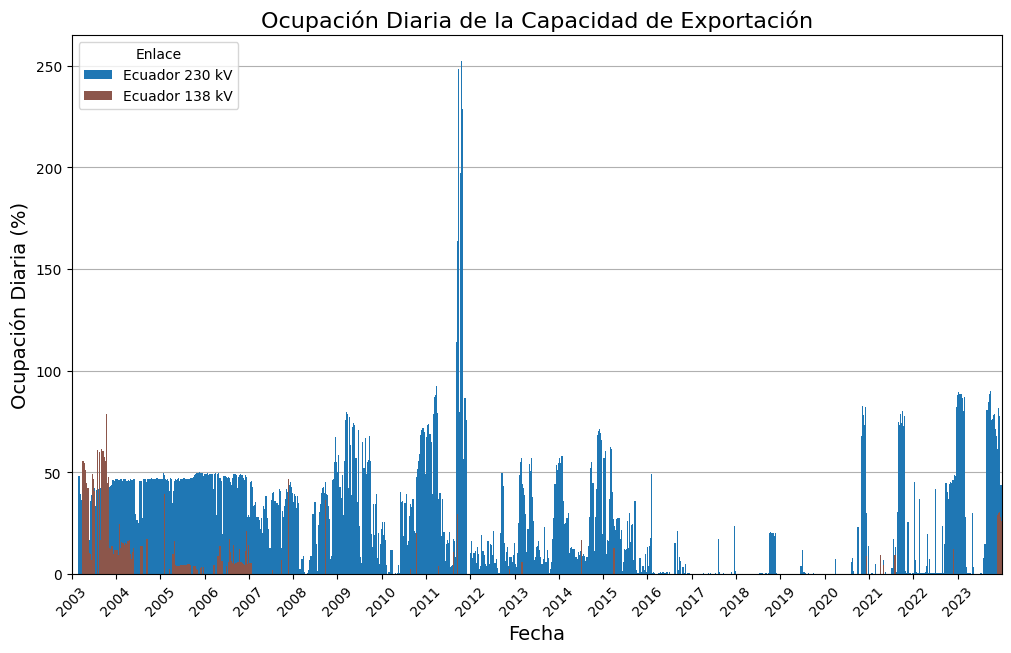

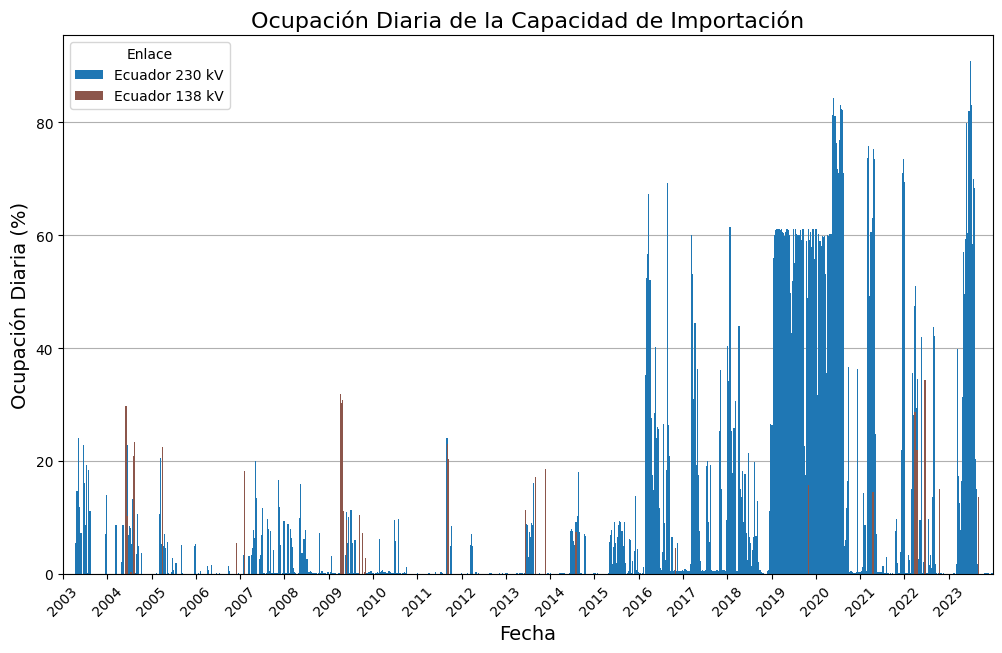

In [144]:
exportaciones_daily = exportaciones_df.groupby(['Fecha', 'Enlace'])['Total_MWh'].sum().reset_index()
importaciones_daily = importaciones_df.groupby(['Fecha', 'Enlace'])['Total_MWh'].sum().reset_index()

# Calculate occupation percentage
def calculate_daily_occupation(df, capacity):
    df['Occupation'] = df.apply(lambda row: (row['Total_MWh']) / (capacity[row['Enlace']] * 24) * 100, axis=1) # Daily Maximum Capacity
    return df

exportaciones_daily = calculate_daily_occupation(exportaciones_daily, capacity)
importaciones_daily = calculate_daily_occupation(importaciones_daily, capacity)

# Plotting function using Matplotlib
def plot_grouped_barplot_daily_occupation(df, title):
    plt.figure(figsize=(12, 7))

    # Pivot the data for grouped bar plot
    df_pivot = df.pivot(index='Fecha', columns='Enlace', values='Occupation').reset_index()

    # Sort by date
    df_pivot = df_pivot.sort_values('Fecha', ascending=True)

    bar_width = 10  # width of the bars

    for i, enlace in enumerate(df['Enlace'].unique()):
        plt.bar(df_pivot['Fecha'] + pd.Timedelta(days=i*bar_width), df_pivot[enlace], width=bar_width, label=enlace, color=custom_palette_enlace[enlace])

    plt.title(title, fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Ocupación Diaria (%)', fontsize=14)

    ax = plt.gca()
    # Set the axis limits
    ax.set_xlim(pd.to_datetime('2003-01-01'), pd.to_datetime('2023-12-31'))

    # Set major ticks format to show the first day of each year as the year
    plt.gca().xaxis.set_major_locator(md.YearLocator())
    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.gca().yaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.legend(title='Enlace')
    plt.show()

plot_grouped_barplot_daily_occupation(exportaciones_daily, 'Ocupación Diaria de la Capacidad de Exportación')
plot_grouped_barplot_daily_occupation(importaciones_daily, 'Ocupación Diaria de la Capacidad de Importación')

### Ocupación Horaria

Data saved to Data_Analysis


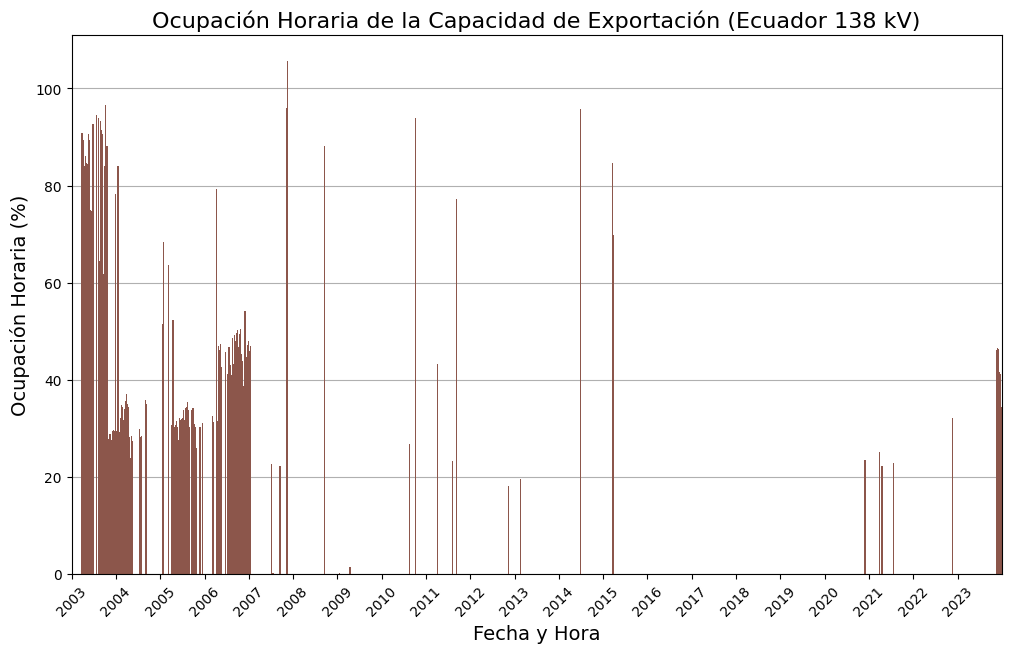

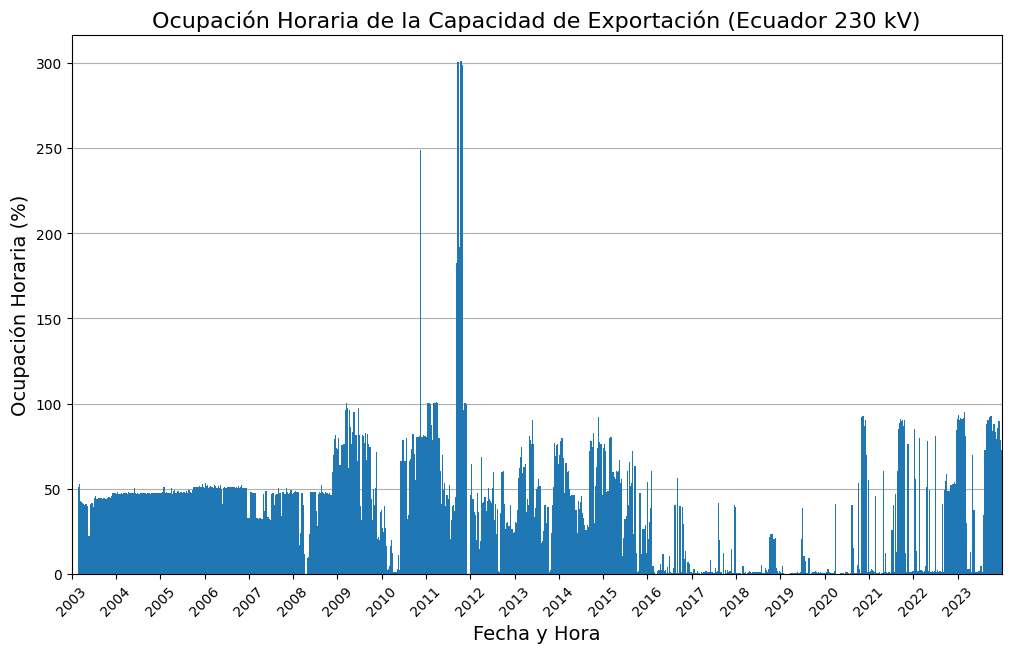

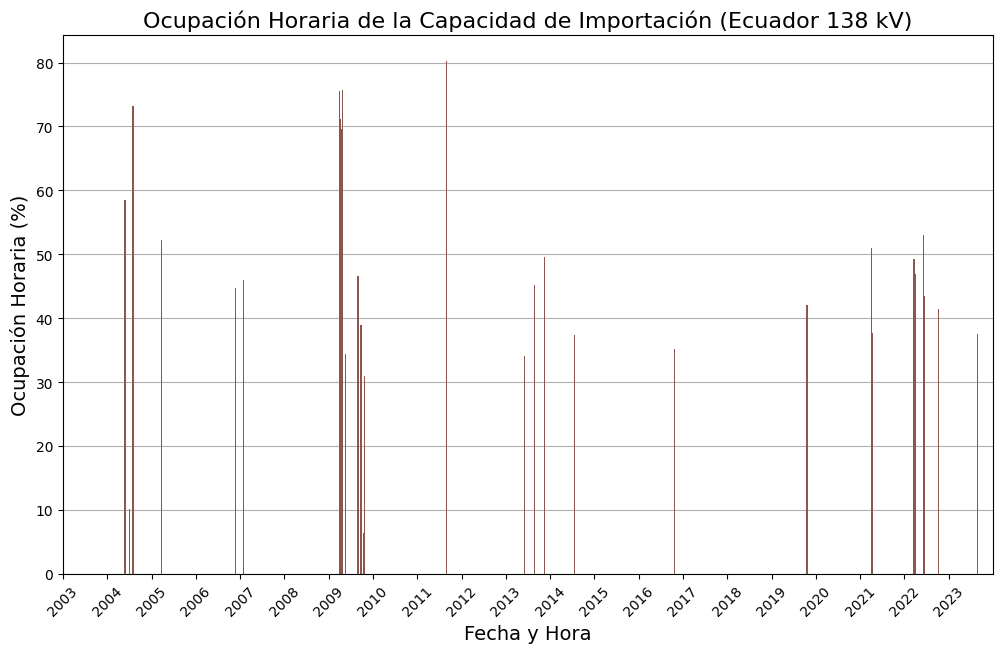

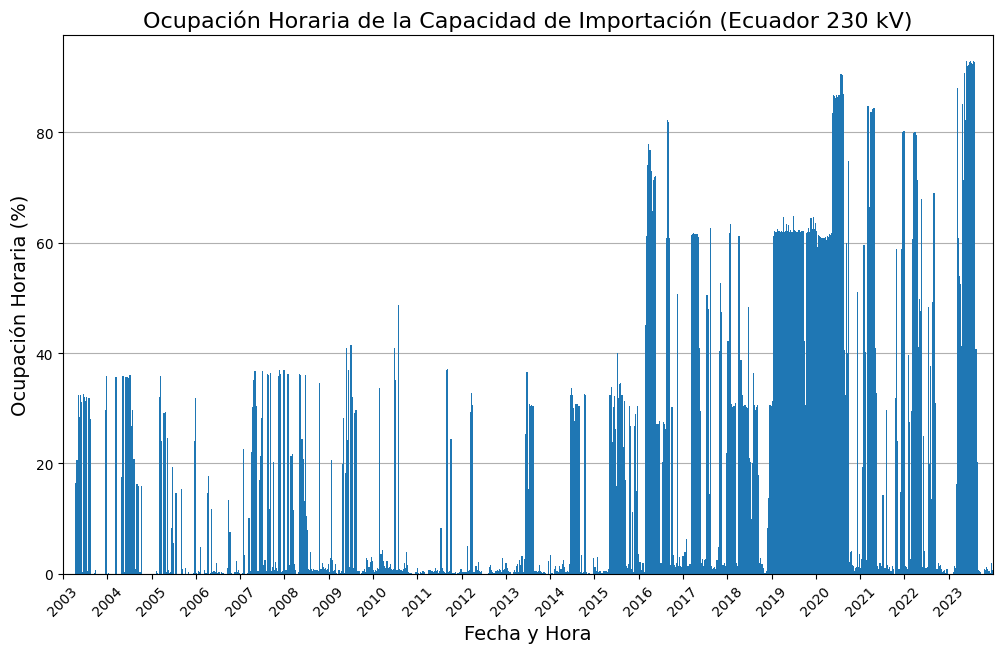

In [145]:
# Create copies of the dataframes for melting
exportaciones_mw_per_hour_df = exportaciones_df.copy()
importaciones_mw_per_hour_df = importaciones_df.copy()

# Convert kWh to MWh for all hourly columns
exportaciones_mw_per_hour_df.iloc[:, 2:26] = exportaciones_mw_per_hour_df.iloc[:, 2:26] / 1e3
importaciones_mw_per_hour_df.iloc[:, 2:26] = importaciones_mw_per_hour_df.iloc[:, 2:26] / 1e3

# print("Exportaciones columns from 2 to 26 (names):")
# print(exportaciones_mw_per_hour_df.columns[2:26])

# print("Importaciones columns from 2 to 26 (names):")
# print(importaciones_mw_per_hour_df.columns[2:26])

# Melt the dataframes to long format to include hourly data
exportaciones_long = pd.melt(exportaciones_mw_per_hour_df.drop(columns=['Total_MWh', 'Total_GWh', 'Year']), id_vars=['Fecha', 'Enlace'], var_name='Hour', value_name='Hourly_MW')
importaciones_long = pd.melt(importaciones_mw_per_hour_df.drop(columns=['Total_MWh', 'Total_GWh', 'Year']), id_vars=['Fecha', 'Enlace'], var_name='Hour', value_name='Hourly_MW')

# Fill NaN or None values in 'Hour' with zero and convert to integer
exportaciones_long['Hour'] = exportaciones_long['Hour'].fillna(0).astype(int)
importaciones_long['Hour'] = importaciones_long['Hour'].fillna(0).astype(int)

# Combine date and hour into a single datetime column
exportaciones_long['Datetime'] = exportaciones_long['Fecha'] + pd.to_timedelta(exportaciones_long['Hour'], unit='h')
importaciones_long['Datetime'] = importaciones_long['Fecha'] + pd.to_timedelta(importaciones_long['Hour'], unit='h')

# Calculate hourly occupation percentage
def calculate_hourly_occupation(df, capacity):
    df['Occupation'] = df.apply(lambda row: ((row['Hourly_MW']) / capacity[row['Enlace']]) * 100, axis=1)
    return df

exportaciones_long = calculate_hourly_occupation(exportaciones_long, capacity)
importaciones_long = calculate_hourly_occupation(importaciones_long, capacity)

exportaciones_long = exportaciones_long.sort_values('Datetime', ascending=True)
importaciones_long = importaciones_long.sort_values('Datetime', ascending=True)

exportaciones_long.to_excel(os.path.join(directory, "Exportaciones_Long_Hourly_MW.xlsx"), index=False)
importaciones_long.to_excel(os.path.join(directory, "Importaciones_Long_Hourly_MW.xlsx"), index=False)
print(f"Data saved to {directory}")

# Plotting function
def plot_hourly_energy_occupation_per_enlace(df, enlace, title):
    plt.figure(figsize=(12, 7))
    df_filtered = df[df['Enlace'] == enlace]
    bar_width = 10
    plt.bar(df_filtered['Datetime'], df_filtered['Occupation'], width=bar_width, color=custom_palette_enlace[enlace])
    plt.title(title, fontsize=16)
    plt.xlabel('Fecha y Hora', fontsize=14)
    plt.ylabel('Ocupación Horaria (%)', fontsize=14)

    ax = plt.gca()
    #ax.set_xticks(pd.date_range(start='2003-01-01', end='2023-12-31', freq='YS'))
    #ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')
    #ax.set_xticklabels([pd.to_datetime(tick).year for tick in ax.get_xticks()])

    # Set the axis limits
    ax.set_xlim(pd.to_datetime('2003-01-01'), pd.to_datetime('2023-12-31'))

    # Set major ticks format to show the first day of each year as the year
    plt.gca().xaxis.set_major_locator(md.YearLocator())
    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y'))

    plt.xticks(rotation=45)
    plt.gca().yaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.show()

# Plot for each Enlace
plot_hourly_energy_occupation_per_enlace(exportaciones_long, 'Ecuador 138 kV', 'Ocupación Horaria de la Capacidad de Exportación (Ecuador 138 kV)')
plot_hourly_energy_occupation_per_enlace(exportaciones_long, 'Ecuador 230 kV', 'Ocupación Horaria de la Capacidad de Exportación (Ecuador 230 kV)')
plot_hourly_energy_occupation_per_enlace(importaciones_long, 'Ecuador 138 kV', 'Ocupación Horaria de la Capacidad de Importación (Ecuador 138 kV)')
plot_hourly_energy_occupation_per_enlace(importaciones_long, 'Ecuador 230 kV', 'Ocupación Horaria de la Capacidad de Importación (Ecuador 230 kV)')

## Descriptive Statistics

In [146]:
# Create copies of the dataframes for calculating statistics
exportaciones_stats_df = exportaciones_df.copy()
importaciones_stats_df = importaciones_df.copy()

exportaciones_stats_df.drop(columns=['Total_MWh', 'Total_GWh', 'Year'])
importaciones_stats_df.drop(columns=['Total_MWh', 'Total_GWh', 'Year'])

exportaciones_stats_df = exportaciones_stats_df.sort_values('Fecha', ascending=True)
importaciones_stats_df = importaciones_stats_df.sort_values('Fecha', ascending=True)

# Function to calculate extended descriptive statistics for each hour by Enlace
def calculate_extended_descriptive_stats_by_enlace(df):
    grouped = df.groupby('Enlace')
    stats_list = []

    for name, group in grouped:
        hours_columns = group.columns[2:26]  # Assuming the hour columns are from the 3rd to 26th column
        descriptive_stats = group[hours_columns].describe().T
        
        # Calculating additional statistics
        descriptive_stats['Variance'] = group[hours_columns].var(axis=0)
        descriptive_stats['Skewness'] = group[hours_columns].skew(axis=0)
        descriptive_stats['Kurtosis'] = group[hours_columns].kurtosis(axis=0)
        descriptive_stats['Range'] = descriptive_stats['max'] - descriptive_stats['min']
        
        # Adding the Enlace column
        descriptive_stats.insert(0, 'Enlace', name)
        
        # Adding the hour column for easier identification
        descriptive_stats.insert(1, 'Hour', descriptive_stats.index)
        
        stats_list.append(descriptive_stats)
    
    return pd.concat(stats_list).reset_index(drop=True)

# Convert kWh to MWh for all hourly columns
exportaciones_stats_df.iloc[:, 2:26] = exportaciones_stats_df.iloc[:, 2:26] / 1e3
importaciones_stats_df.iloc[:, 2:26] = importaciones_stats_df.iloc[:, 2:26] / 1e3

# Calculate extended descriptive statistics
exportaciones_stats = calculate_extended_descriptive_stats_by_enlace(exportaciones_stats_df)
importaciones_stats = calculate_extended_descriptive_stats_by_enlace(importaciones_stats_df)

# Saving the extended descriptive statistics
exportaciones_stats.to_excel(f"{directory}/Extended_Stats_Exportaciones_MWh.xlsx", index=False)
importaciones_stats.to_excel(f"{directory}/Extended_Stats_Importaciones_MWh.xlsx", index=False)

# # Display the statistics
# print("Exportaciones Statistics:")
# print(exportaciones_stats)

# print("\nImportaciones Statistics:")
# print(importaciones_stats)

In [147]:
# Create copies of the dataframes for calculating statistics
exportaciones_used_df = exportaciones_df.copy()
importaciones_used_df = importaciones_df.copy()

exportaciones_used_df = exportaciones_used_df.drop(columns=['Total_GWh'])
importaciones_used_df = importaciones_used_df.drop(columns=['Total_GWh'])

exportaciones_used_df = exportaciones_used_df.sort_values('Fecha', ascending=True)
importaciones_used_df = importaciones_used_df.sort_values('Fecha', ascending=True)

# Create a range of years from 2003 to 2023
years_range = pd.DataFrame({'Year': range(2003, 2024)})

# Function to count days used per year
def count_days_used_per_year(df):
    # Create a column to indicate if the day was used
    df['Used'] = df['Total_MWh'] > 0
    
    # Extract year from the 'Fecha' column
    df['Year'] = df['Fecha'].dt.year
    
    # Group by 'Enlace' and 'Year' and count the number of days used
    days_used = df[df['Used']].groupby(['Enlace', 'Year']).size().reset_index(name='Days_Used')
    
    return days_used

# Count days used per year for exportaciones and importaciones
exportaciones_days_used = count_days_used_per_year(exportaciones_df)
importaciones_days_used = count_days_used_per_year(importaciones_df)

# Function to ensure all years are included and pivot the table
def create_pivot_table(days_used):
    enlaces = days_used['Enlace'].unique()
    all_years_data = []

    for enlace in enlaces:
        enlace_data = days_used[days_used['Enlace'] == enlace]
        complete_data = years_range.merge(enlace_data, on='Year', how='left').fillna({'Days_Used': 0})
        complete_data['Enlace'] = enlace
        all_years_data.append(complete_data)

    # Combine all the data with complete years
    final_days_used = pd.concat(all_years_data)

    # Pivot the table to get the desired format
    pivot_table = final_days_used.pivot(index='Year', columns='Enlace', values='Days_Used').reset_index()

    # Fill missing values with 0
    pivot_table = pivot_table.fillna(0).astype(int)

    return pivot_table

# Create pivot tables for exportaciones and importaciones
pivot_table_exportaciones = create_pivot_table(exportaciones_days_used)
pivot_table_importaciones = create_pivot_table(importaciones_days_used)

# Save the results to Excel files
pivot_table_exportaciones.to_excel(f"{directory}/Days_Used_Exportaciones.xlsx", index=False)
pivot_table_importaciones.to_excel(f"{directory}/Days_Used_Importaciones.xlsx", index=False)

# # Display the results
# print("Exportaciones Days Used Per Year:")
# print(pivot_table_exportaciones)

# print("\nImportaciones Days Used Per Year:")
# print(pivot_table_importaciones)